#### Importing packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import plotly as py
import plotly.express as px
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

#### Functions

In [2]:
# Function to remove missing values above a given threshold
def missing_remove(dataframe, threshold):
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold].tolist()
    print(f"# Features deleted with more than {threshold} % missing values", len(columns))
    return dataframe.drop(columns, axis=1,inplace=True)

In [3]:
# Function to remove features with unique values
def unique_remove(dataframe):
    unique_features = []
    for col in dataframe.columns:
        if(dataframe[col].unique().size == 2):
            if(len(unique_features) == 0):
                unique_features =  dataframe[col]
            else:
                 unique_features = pd.concat([unique_features, dataframe[col]], axis=1)
            dataframe.drop(col, axis=1, inplace=True)

In [4]:
# Function to remove outlier
def outlier_detection_zcore(dataframe):
    data_mean, data_std  = dataframe.mean(), dataframe.std()
    data_z_scores = ((dataframe - data_mean) / data_std).abs()
    m = data_z_scores > 3
    dataframe = dataframe.mask(m,inplace=True)
    return dataframe

In [5]:
def rfc(X_train_rfc,X_test_rfc,y_train,max_depth):
  from matplotlib.pyplot import figure
  figure(figsize=(8, 5), dpi=80)
  model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=max_depth)
  model.fit(X_train_rfc, y_train)
  y_pred = model.predict(X_test_rfc)
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",yticklabels = ['Act. Pass', 'Act. Fail'], xticklabels = ['Pred. Pass' , 'Pred. Fail'])
  print(classification_report(y_test, y_pred))
  print("Test Accuracy Score", accuracy_score(y_test, y_pred))
  print("Train Accuracy Score", accuracy_score(y_train, model.predict(X_train_rfc)))
  print("F1 Score",f1_score(y_test, y_pred, average='micro'))
  print("MC Score",matthews_corrcoef(y_test, y_pred))
#   #create ROC curve
#   plt.plot(fpr,tpr,label='Random Forest Classifier (AUC = %0.2f)' % auc)
#   plt.ylabel('True Positive Rate')
#   plt.xlabel('False Positive Rate')
#   plt.plot([0, 1], [0, 1],'r--')
#   plt.xlim([-0.01, 1.0])
#   plt.ylim([0.0, 1.05])
#   plt.title('Receiver Operating Characteristic')
#   plt.legend(loc="lower right")

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, matthews_corrcoef
from yellowbrick.classifier import ConfusionMatrix, ClassPredictionError
def evaluate(train_df, test_df, train_target, test_target):
    
    scaler = StandardScaler()
    scaler.fit(train_df)
    train_std = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
    test_std = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
    
    logreg = LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear')
    logreg.fit(train_std, train_target.values.ravel())
    
    y_pred = logreg.predict(test_std)
    y_true = test_target.values.ravel()
    f1score = f1_score(y_true, y_pred, average='micro')
    mccscore=matthews_corrcoef(y_true, y_pred)
    
   
    cm = ConfusionMatrix(logreg, classes=['Fail', 'Pass'], cmap="YlGn", size=(400,400))
    cm.score(test_std, y_true)
    cm.show()
    from matplotlib.pyplot import figure
    figure(figsize=(5, 5), dpi=80)
    ax = plt.gca()
    plot = plot_roc_curve(logreg, test_df, test_target, ax=ax, alpha=0.8)
    
    return f1score, mccscore

#### Importing and basic cleaning

In [7]:
# Importing data from internet in runtime
data_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"

In [8]:
# Assigning data to a pandas dataframe
secom_data = pd.read_csv(data_url,sep=' ',header=None)

In [9]:
# Renaming the columns 
secom_data.columns = ["Feature_"+str(column+1) for column in range(len(secom_data.columns))]
secom_data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_581,Feature_582,Feature_583,Feature_584,Feature_585,Feature_586,Feature_587,Feature_588,Feature_589,Feature_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [10]:
# Importing target data from internet in runtime
label_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

In [11]:
# Assigning target data to a pandas dataframe
secom_labels = pd.read_csv(label_url, sep = " ",header=None)

In [12]:
# Renaming the columns 
secom_labels.columns = ["Classification","Timestamp"]

In [13]:
# Changing datatype for consitency
secom_labels['Timestamp'] = pd.to_datetime(secom_labels['Timestamp'],errors='raise')

In [14]:
# Merging the data
data= pd.concat([secom_labels,secom_data],axis=1)

In [15]:
# Dropping the timestamp column as it provides no insights
data.drop(columns="Timestamp", errors='raise',inplace=True)

In [16]:
target = data[['Classification']]
data.drop(['Classification'], axis=1,inplace=True)

#### Spliting the data into training set and test set

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.20, random_state=42, stratify=target)
# We use the startify parameter as the data is imbalanced on the basis of pass and fail and this will ensure the same 
#is retained when we split - Random state will help us create a reproducible data - Test size is the split ration

In [18]:
X_test_original = X_test

#### Re-labeling the Target values


In [19]:
# Relabeling target variables 1 is pass and 0 is fail
# y_train = y_train.replace(to_replace=[-1, 1], value=[1, 0])
# y_test = y_test.replace(to_replace=[-1, 1], value=[1, 0])

In [20]:
# # Scaling the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Decision : Removing columns with more that 50% missing values

In [21]:
X_train.shape

(1253, 590)

In [22]:
X_train_missing = X_train
missing_remove(X_train_missing, 0.5)
X_train_missing.shape

# Features deleted with more than 0.5 % missing values 32


(1253, 558)

In [23]:
# From test set deleting columns that are removed in training set
X_test_missing = X_test[np.array(X_train_missing.columns)]
X_test_missing.shape

(314, 558)

# Decision : Replacing outliers with 3s boundary

##### Other option of removing outliers and replacing them has been explored in file "Base file - removing outliers and replacing with knn.ipynb"

In [24]:
def replace_outlier(val, mean, std):
    if val > mean + 3*std:
        return mean + 3*std 
    elif val < mean - 3*std:
        return mean - 3*std
    return val

In [25]:
# replace with 3s in X_train
for col in X_train_missing.columns:
    mean = X_train_missing[col].mean()
    std_dev = X_train_missing[col].std(axis=0)
    X_train_missing[col] = X_train_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

In [26]:
# replace with 3s in X_test
for col in X_test_missing.columns:
    mean = X_test_missing[col].mean()
    std_dev = X_test_missing[col].std(axis=0)
    X_test_missing[col] = X_test_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

# KNN Imputation

In [27]:
from sklearn.impute import KNNImputer
knn = KNNImputer()
knn.fit(X_train_missing)
X_train_knn=pd.DataFrame(knn.transform(X_train_missing), columns=X_train_missing.columns)
X_train_knn.isna().sum().sum()

0

In [28]:
from sklearn.impute import KNNImputer
knn = KNNImputer()
knn.fit(X_test_missing)
X_test_knn=pd.DataFrame(knn.transform(X_test_missing), columns=X_test_missing.columns)
X_test_knn.isna().sum().sum()

0

              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314

Test Accuracy Score 0.9331210191082803
Train Accuracy Score 0.9337589784517158
F1 Score 0.9331210191082803
MC Score 0.0


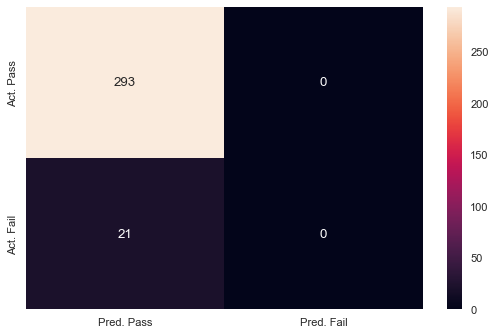

In [29]:
rfc(X_train_knn,X_test_knn,y_train,4)

# Feature Selection

## Forward Feature Selection

In [62]:
#importing the necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),k_features=15,forward=True,verbose=True,scoring='neg_mean_squared_error')

In [63]:
sfs.fit(X_train_knn, y_train)
sfs_list = list(sfs.k_feature_names_)
print(sfs_list)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed:    8.5s finished
Features: 1/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed:    9.6s finished
Features: 2/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 556 out of 556 | elapsed:    9.3s finished
Features: 3/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 555 out of 555 | elapsed:   10.1s finished
Features: 4/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 554 out of 554 | elapsed:    9.5s finished
Features: 5/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 553 out of 553 | elapsed:    9.6s finished
Features: 6/15[Parallel(

['Feature_22', 'Feature_60', 'Feature_65', 'Feature_76', 'Feature_104', 'Feature_122', 'Feature_130', 'Feature_206', 'Feature_282', 'Feature_320', 'Feature_434', 'Feature_481', 'Feature_485', 'Feature_542', 'Feature_574']


In [64]:
# creating a new dataframe using the above variables and adding the target variable
X_train_sfs = X_train_knn[sfs_list]

In [65]:
# From test set deleting columns that are removed in training set
X_test_sfs = X_test_knn[np.array(X_train_sfs.columns)]
X_test_sfs.shape

(314, 15)

              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314

Test Accuracy Score 0.9331210191082803
Train Accuracy Score 0.945730247406225
F1 Score 0.9331210191082803
MC Score 0.0


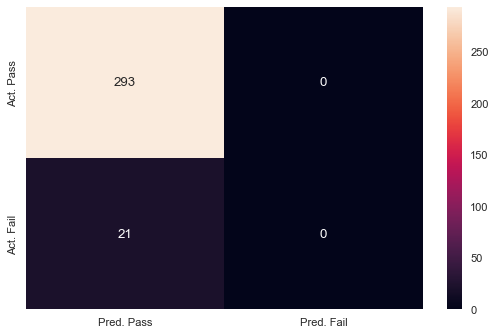

In [66]:
rfc(X_train_sfs,X_test_sfs,y_train,6)

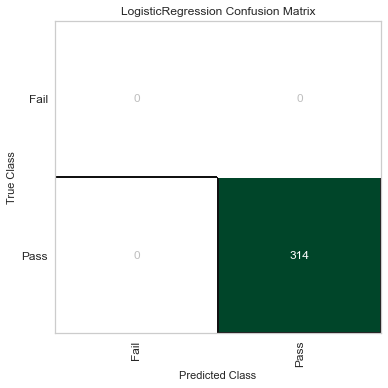

(0.7929936305732486, 0.23064837009575476)

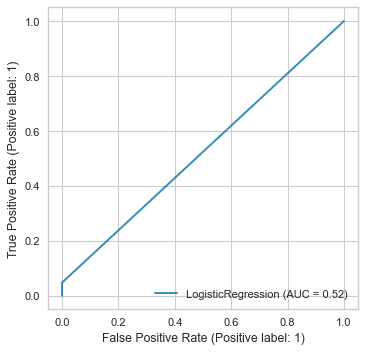

In [67]:
evaluate(X_train_sfs,X_test_sfs,y_train,y_test)

<AxesSubplot:>

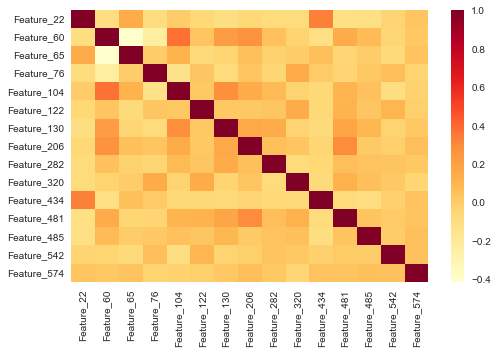

In [68]:
import seaborn as sns
# Heatmap for correlation
plt.rcParams['figure.figsize'] = (8,5)
sns.heatmap(X_train_sfs.corr(),cmap="YlOrRd")
#plt.title('Heatmap for the Data', fontsize = 50)

## Balancing usnig SMOTE

In [69]:
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

In [70]:
from imblearn.combine import SMOTETomek 
# Sampling technique

def Sampling(X_train, y_train, sampler):

    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
    # SMOTETOMEK
    
    if sampler == 'SMOTETOMEK' :
        sampler = SMOTETomek(random_state=100)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
        
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)
        

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [71]:
# Imbalance treatment
from collections import Counter
X_smote, y_smote = Sampling(X_train_sfs, y_train,'SMOTE')

Counter({'Classification': 1})


              precision    recall  f1-score   support

          -1       0.95      0.90      0.92       293
           1       0.19      0.33      0.25        21

    accuracy                           0.86       314
   macro avg       0.57      0.62      0.59       314
weighted avg       0.90      0.86      0.88       314

Test Accuracy Score 0.8630573248407644
Train Accuracy Score 0.9329059829059829
F1 Score 0.8630573248407644
MC Score 0.18375880354300733


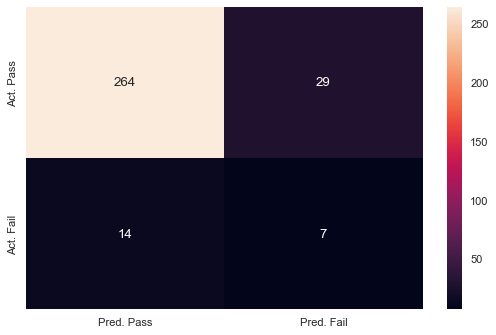

In [72]:
rfc(X_smote,X_test_sfs,y_smote,6)

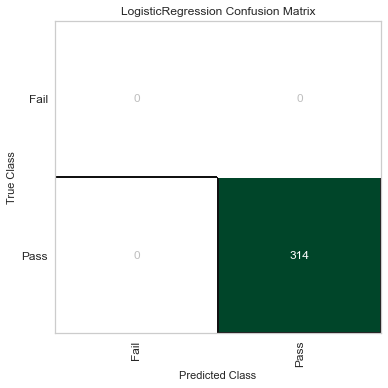

(0.7961783439490446, 0.23397348914515137)

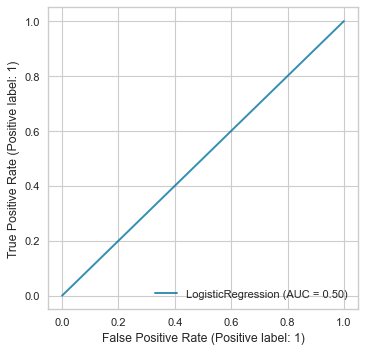

In [73]:
evaluate(X_smote,X_test_sfs,y_smote,y_test)

## Smoteenn

In [74]:
# Imbalance treatment
from imblearn.combine import SMOTEENN
X_smoteenn, y_smoteenn = Sampling(X_train_sfs, y_train,'SMOTEENN')

Counter({'Classification': 1})


              precision    recall  f1-score   support

          -1       0.96      0.81      0.88       293
           1       0.17      0.52      0.25        21

    accuracy                           0.79       314
   macro avg       0.56      0.67      0.57       314
weighted avg       0.91      0.79      0.84       314

Test Accuracy Score 0.7929936305732485
Train Accuracy Score 0.9494280553883203
F1 Score 0.7929936305732486
MC Score 0.20606738916128214


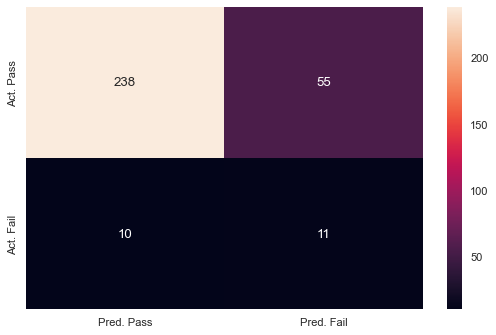

In [75]:
rfc(X_smoteenn,X_test_sfs,y_smoteenn,6)

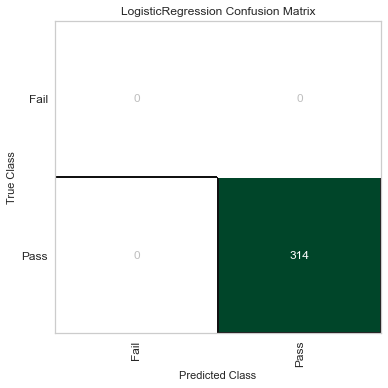

(0.7866242038216562, 0.24820797681558954)

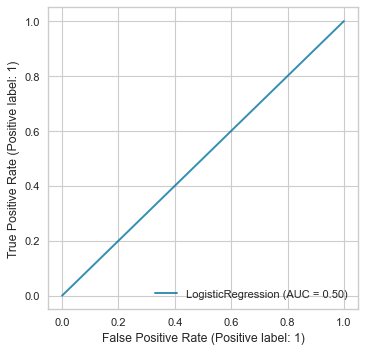

In [76]:
evaluate(X_smoteenn,X_test_sfs,y_smoteenn,y_test)

## Smotetomek

In [77]:
# Imbalance treatment
X_smotetomek, y_smotetomek = Sampling(X_train_sfs, y_train,'SMOTETOMEK')

Counter({'Classification': 1})


              precision    recall  f1-score   support

          -1       0.95      0.89      0.92       293
           1       0.18      0.33      0.23        21

    accuracy                           0.85       314
   macro avg       0.56      0.61      0.58       314
weighted avg       0.90      0.85      0.87       314

Test Accuracy Score 0.8535031847133758
Train Accuracy Score 0.9287587412587412
F1 Score 0.8535031847133757
MC Score 0.16975483710675693


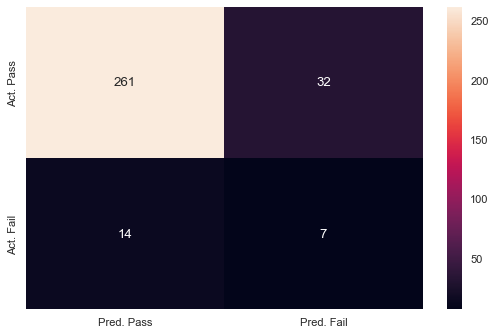

In [78]:
rfc(X_smotetomek,X_test_sfs,y_smotetomek,6)

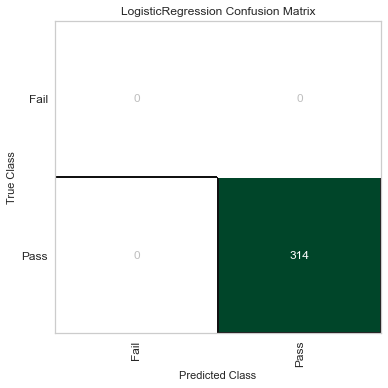

(0.7961783439490446, 0.23397348914515137)

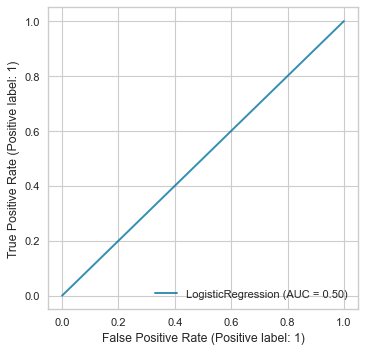

In [79]:
evaluate(X_smotetomek,X_test_sfs,y_smotetomek,y_test)

## Adasyn

In [80]:
# Imbalance treatment
X_adasyn, y_adasyn = Sampling(X_train_sfs, y_train,'ADASYN')

Counter({'Classification': 1})


              precision    recall  f1-score   support

          -1       0.95      0.88      0.91       293
           1       0.16      0.33      0.22        21

    accuracy                           0.84       314
   macro avg       0.56      0.61      0.57       314
weighted avg       0.90      0.84      0.87       314

Test Accuracy Score 0.8407643312101911
Train Accuracy Score 0.9256055363321799
F1 Score 0.8407643312101911
MC Score 0.15293519375904202


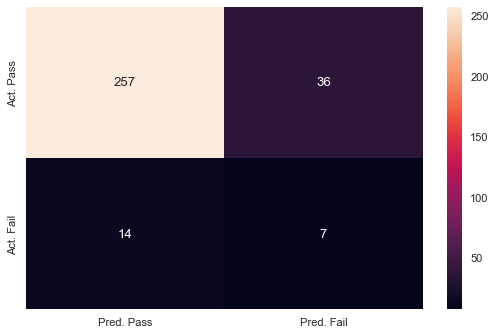

In [81]:
rfc(X_adasyn,X_test_sfs,y_adasyn,6)

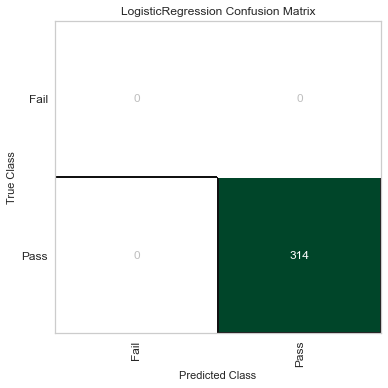

(0.802547770700637, 0.2407986020958898)

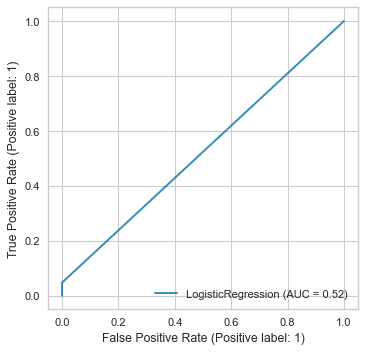

In [82]:
evaluate(X_adasyn,X_test_sfs,y_adasyn,y_test)

In [83]:
# Imbalance treatment
X_rose, y_rose = Sampling(X_train_sfs, y_train,'ROSE')

Counter({'Classification': 1})


              precision    recall  f1-score   support

          -1       0.96      0.91      0.94       293
           1       0.28      0.48      0.35        21

    accuracy                           0.88       314
   macro avg       0.62      0.69      0.64       314
weighted avg       0.91      0.88      0.90       314

Test Accuracy Score 0.8821656050955414
Train Accuracy Score 0.8961538461538462
F1 Score 0.8821656050955414
MC Score 0.3038009623068859


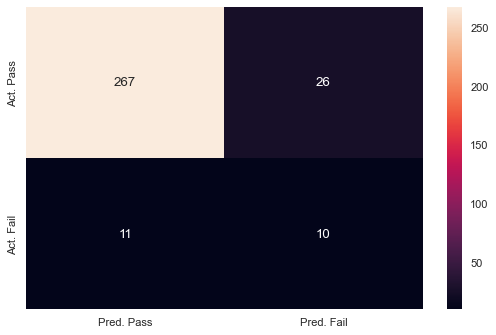

In [91]:
rfc(X_rose,X_test_sfs,y_rose,6)


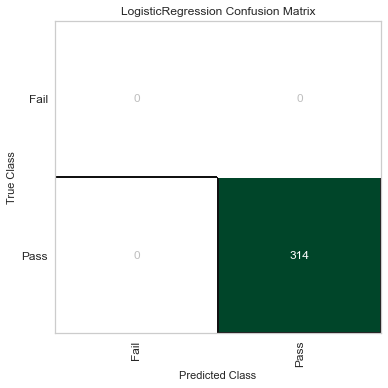

(0.7898089171974523, 0.25147316297244676)

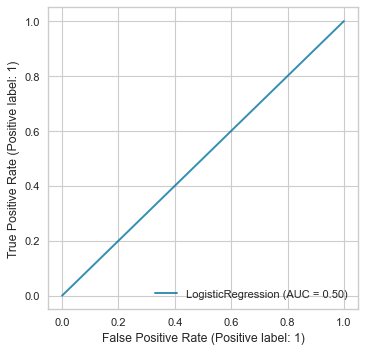

In [85]:
evaluate(X_rose,X_test_sfs,y_rose,y_test)

<AxesSubplot:>

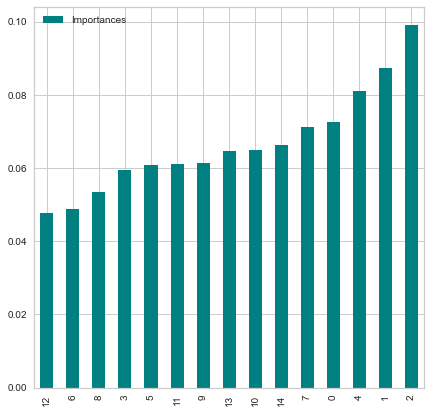

In [86]:
model = RandomForestClassifier()
model.fit(X_train_sfs, y_train.values.ravel())
    
feature_selector = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    
importances = model.feature_importances_
final_df = pd.DataFrame({"Features": pd.DataFrame(X_train_sfs).columns, "Importances": importances})
final_df.set_index('Importances')
final_df = final_df.sort_values('Importances')
final_df.plot.bar(color = 'teal',figsize=(7,7))

In [87]:
# define the tree depths to evaluate
values = [i for i in range(1, 21)]

In [88]:
from sklearn.tree import DecisionTreeClassifier
# evaluate a decision tree for each depth
test_scores=[]
train_scores=[]
for i in values:
    # configure the model
    model = RandomForestClassifier(max_depth=i)
    # fit model on the training dataset
    model.fit(X_train_sfs, y_train)
    # evaluate on the train dataset
    train_yhat = model.predict(X_train_sfs)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = model.predict(X_test_sfs)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # summarize progress
    print('%d train: %.3f, test: %.3f' % (i, train_acc, test_acc))

1 train: 0.934, test: 0.933
2 train: 0.934, test: 0.933
3 train: 0.934, test: 0.933
4 train: 0.935, test: 0.933
5 train: 0.937, test: 0.933
6 train: 0.946, test: 0.933
7 train: 0.958, test: 0.933
8 train: 0.968, test: 0.933
9 train: 0.975, test: 0.933
10 train: 0.986, test: 0.936
11 train: 0.989, test: 0.936
12 train: 0.996, test: 0.936
13 train: 0.998, test: 0.936
14 train: 0.999, test: 0.939
15 train: 0.999, test: 0.939
16 train: 0.999, test: 0.936
17 train: 0.999, test: 0.936
18 train: 1.000, test: 0.939
19 train: 1.000, test: 0.936
20 train: 1.000, test: 0.933


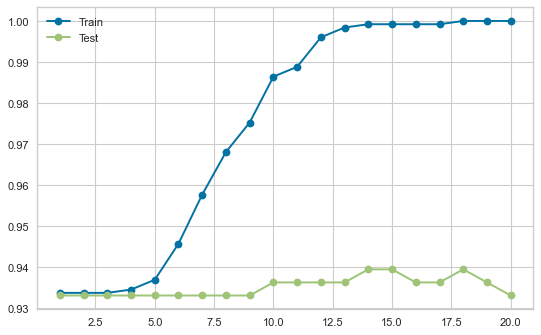

In [89]:
import matplotlib
import matplotlib.pyplot as pyplot
from matplotlib.pyplot import figure
figure(figsize=(8, 5), dpi=80)
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

Text(0.5, 0, 'Random Forest Feature Importance')

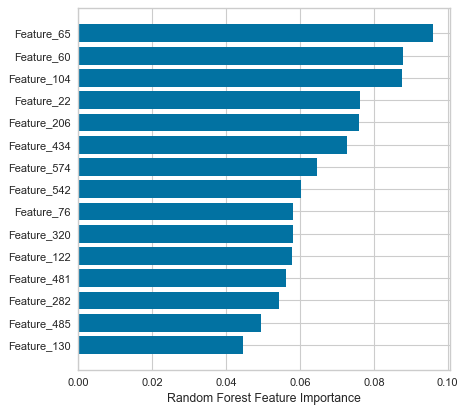

In [90]:
model = RandomForestClassifier()
model.fit(X_train_sfs, y_train.values.ravel())
feature_selector = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
figure(figsize=(6, 6), dpi=80)
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train_sfs.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")